In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [15]:
data=pd.read_csv('/content/drive/MyDrive/GRU/wti_prices.csv')
data

,date,open,high,low,close,volume,average
0,2024-04-04,75.90,76.71,75.44,76.46,4467.0,76.149
1,2024-04-05,76.54,76.91,76.23,76.41,3429.0,76.552
2,2024-04-08,76.57,76.74,75.54,76.18,2276.0,76.070
3,2024-04-09,76.42,76.52,75.48,75.63,1811.0,75.900
4,2024-04-10,76.01,76.48,75.45,76.27,3500.0,76.077
...,...,...,...,...,...,...,...
2076,2017-03-30,54.95,54.95,54.95,54.95,0.0,54.950
2077,2017-03-31,55.44,55.44,55.44,55.44,0.0,55.440
2078,2017-04-03,55.83,55.83,55.83,55.83,0.0,55.830
2079,2017-04-04,56.18,56.18,56.18,56.18,0.0,56.180


# **Kiểm tra dữ liệu với tập Wti_prices**

In [16]:
# kiểm tra dữ liệu Chuyển date sang datetime  Sắp xếp theo thời gian Đặt date làm index
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data = data.dropna(subset=['date'])   # nếu có dòng nào date lỗi thì bỏ
data = data.sort_values('date')

# xóa các dòng trùng toàn bộ (nếu có)
data = data.drop_duplicates()

# đặt date làm index
data = data.set_index('date')
# đảm bảo mỗi date chỉ còn 1 dòng
data = data[~data.index.duplicated(keep='first')]
print("Số dòng trùng theo date:", data.index.duplicated(keep=False).sum())
print(data.head())

Số dòng trùng theo date: 0
             open   high    low  close  volume  average
date                                                   
2016-11-23  58.66  58.66  58.66  58.66     0.0    58.66
2016-11-25  57.32  57.32  57.32  57.32     0.0    57.32
2016-11-28  57.85  57.85  57.85  57.85     0.0    57.85
2016-11-29  56.51  56.51  56.51  56.51     0.0    56.51
2016-11-30  58.29  58.29  58.29  58.29     0.0    58.29


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2078 entries, 2016-11-23 to 2025-04-03
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   open     2078 non-null   float64
 1   high     2078 non-null   float64
 2   low      2078 non-null   float64
 3   close    2078 non-null   float64
 4   volume   2078 non-null   float64
 5   average  2078 non-null   float64
dtypes: float64(6)
memory usage: 178.2 KB


In [19]:
data.describe()


,open,high,low,close,volume,average
count,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000
mean,59.636858,59.756655,59.489731,59.616304,794.619346,59.625703
std,9.672567,9.805254,9.510876,9.649170,2671.145792,9.661230
min,40.390000,40.390000,40.390000,40.390000,0.000000,40.390000
25%,52.260000,52.260000,52.260000,52.260000,0.000000,52.260000
50%,55.720000,55.745000,55.695000,55.725000,0.000000,55.720000
75%,69.275000,69.580000,69.002500,69.250000,38.000000,69.287250
max,79.010000,79.140000,79.010000,79.010000,35933.000000,79.010000


In [20]:
data.isnull().sum()


,0
open,0
high,0
low,0
close,0
volume,0
average,0


In [21]:
# kiểm tra dữ liệu ngoại lại

numeric_cols = ['open', 'high', 'low', 'close', 'volume', 'average']

Q1 = data[numeric_cols].quantile(0.25)
Q3 = data[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

outlier_mask = (data[numeric_cols] < (Q1 - 1.5 * IQR)) | (data[numeric_cols] > (Q3 + 1.5 * IQR))
outlier_counts = outlier_mask.sum()

print("Số outlier theo cột:")
print(outlier_counts)

print("\nTỉ lệ outlier theo cột (%):")
print((outlier_counts / len(data) * 100).round(2))


Số outlier theo cột:
open         0
high         0
low          0
close        0
volume     468
average      0
dtype: int64

Tỉ lệ outlier theo cột (%):
open        0.00
high        0.00
low         0.00
close       0.00
volume     22.52
average     0.00
dtype: float64


## Trực quan **EDA**

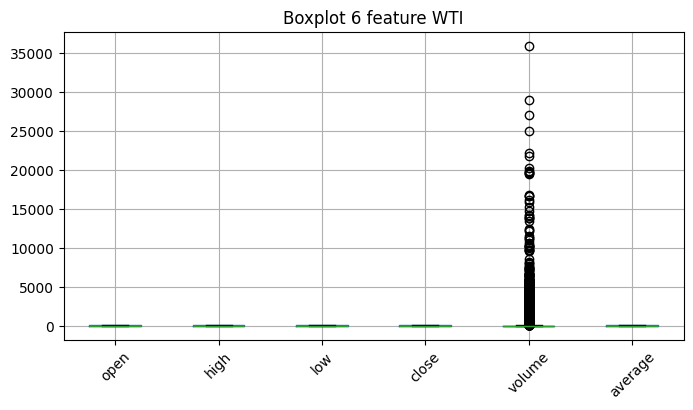

In [22]:

plt.figure(figsize=(8,4))
data[numeric_cols].boxplot()
plt.title("Boxplot 6 feature WTI")
plt.xticks(rotation=45)
plt.show()


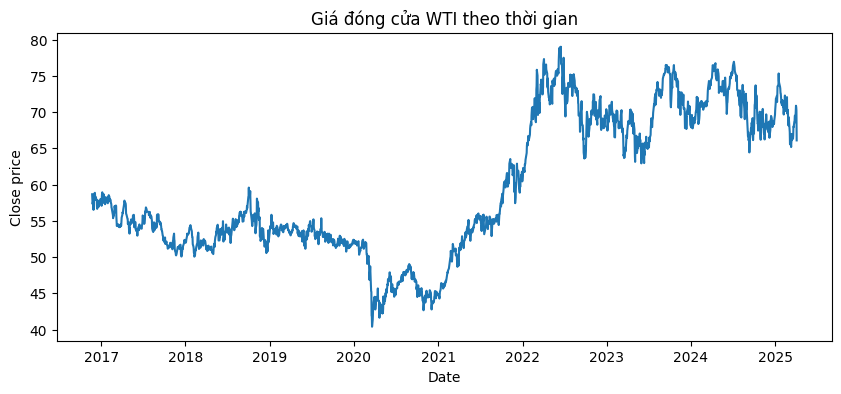

In [23]:


plt.figure(figsize=(10,4))
plt.plot(data.index, data['close'])
plt.title('Giá đóng cửa WTI theo thời gian')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.show()


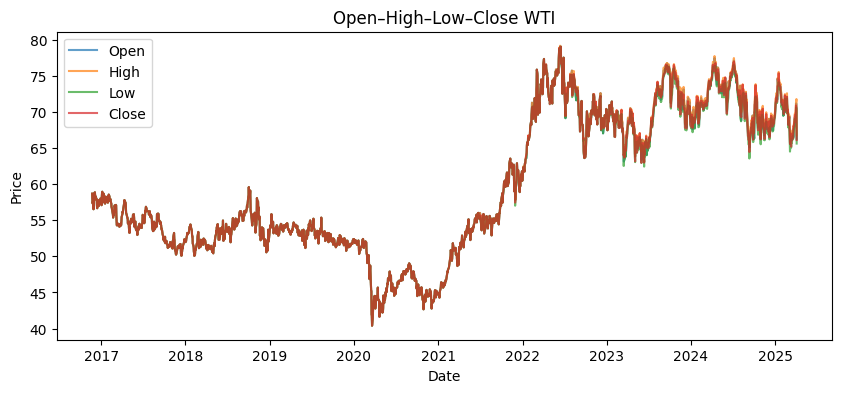

In [24]:
plt.figure(figsize=(10,4))
plt.plot(data.index, data['open'],  label='Open',  alpha=0.7)
plt.plot(data.index, data['high'],  label='High',  alpha=0.7)
plt.plot(data.index, data['low'],   label='Low',   alpha=0.7)
plt.plot(data.index, data['close'], label='Close', alpha=0.7)
plt.legend()
plt.title('Open–High–Low–Close WTI')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


# Chuẩn bị dữ liệu cho **GRU**

In [25]:

# 6 feature làm input
features = data[['open', 'high', 'low', 'close', 'volume', 'average']].copy()

# target là close
target = data[['close']].copy()


In [27]:
# chia tập dữ liệu theo thời gian
N = len(features)
train_size = int(N * 0.7)
val_size   = int(N * 0.15)

features_train = features.iloc[:train_size]
features_val   = features.iloc[train_size:train_size+val_size]
features_test  = features.iloc[train_size+val_size:]

target_train   = target.iloc[:train_size]
target_val     = target.iloc[train_size:train_size+val_size]
target_test    = target.iloc[train_size+val_size:]


In [30]:
# Scale X và y (fit trên train, dùng lại cho val/test)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_all = scaler_X.fit_transform(features_train)
X_val_all   = scaler_X.transform(features_val)
X_test_all  = scaler_X.transform(features_test)

y_train_all = scaler_y.fit_transform(target_train)
y_val_all   = scaler_y.transform(target_val)
y_test_all  = scaler_y.transform(target_test)


In [32]:
#Tạo các sequence (window = 60 ngày)
WINDOW_SIZE = 60

def create_sequences_multi(X, y, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i-window_size:i, :])  # (60, 6)
        ys.append(y[i, 0])                # close ngày i
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences_multi(X_train_all, y_train_all, WINDOW_SIZE)
X_val,   y_val   = create_sequences_multi(X_val_all,   y_val_all,   WINDOW_SIZE)
X_test,  y_test  = create_sequences_multi(X_test_all,  y_test_all,  WINDOW_SIZE)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val  :", X_val.shape)
print("X_test :", X_test.shape)


X_train: (1394, 60, 6)
y_train: (1394,)
X_val  : (251, 60, 6)
X_test : (253, 60, 6)


# 5. Xây và train mô hình **GRU**

In [36]:

# số feature cố định là 6
n_features = X_train_all.shape[1]

# các giá trị hyperparameter sẽ thử
window_sizes = [30, 60, 90]         # có thể thêm 90 nếu bạn muốn
gru_units    = [32, 64]
dropouts     = [0.2, 0.3]
batch_sizes  = [16, 32]

results = []

for win in window_sizes:
    # tạo sequence cho train/val với window_size = win
    Xtr_seq, ytr_seq = create_sequences_multi(X_train_all, y_train_all, win)
    Xval_seq, yval_seq = create_sequences_multi(X_val_all, y_val_all, win)

    print(f"\n=== Window size = {win} ===")
    print("Train seq shape:", Xtr_seq.shape, "Val seq shape:", Xval_seq.shape)

    for units in gru_units:
        for dr in dropouts:
            for bs in batch_sizes:
                tf.keras.backend.clear_session()  # dọn bộ nhớ model cũ

                model = Sequential([
                    GRU(units, return_sequences=True,
                        input_shape=(win, n_features)),
                    Dropout(dr),
                    GRU(units // 2),
                    Dropout(dr),
                    Dense(1)
                ])

                model.compile(
                    loss='mse',
                    optimizer='adam',
                    metrics=['mae']
                )

                es = EarlyStopping(
                    monitor='val_loss',
                    patience=3,
                    restore_best_weights=True
                )

                history = model.fit(
                    Xtr_seq, ytr_seq,
                    epochs=30,              # grid search chỉ cần ít epoch
                    batch_size=bs,
                    validation_data=(Xval_seq, yval_seq),
                    callbacks=[es],
                    verbose=0
                )

                val_loss, val_mae = model.evaluate(Xval_seq, yval_seq, verbose=0)

                config_result = {
                    'window'   : win,
                    'units'    : units,
                    'dropout'  : dr,
                    'batch'    : bs,
                    'val_loss' : val_loss,
                    'val_mae'  : val_mae
                }
                results.append(config_result)
                print(config_result)

# đưa kết quả vào DataFrame và sắp xếp theo val_loss tăng dần
results_df = pd.DataFrame(results).sort_values('val_loss')
results_df



=== Window size = 30 ===
Train seq shape: (1424, 30, 6) Val seq shape: (281, 30, 6)
{'window': 30, 'units': 32, 'dropout': 0.2, 'batch': 16, 'val_loss': 0.001039664726704359, 'val_mae': 0.025122394785284996}
{'window': 30, 'units': 32, 'dropout': 0.2, 'batch': 32, 'val_loss': 0.0035047908313572407, 'val_mae': 0.0463762991130352}
{'window': 30, 'units': 32, 'dropout': 0.3, 'batch': 16, 'val_loss': 0.0010012970305979252, 'val_mae': 0.02496424876153469}
{'window': 30, 'units': 32, 'dropout': 0.3, 'batch': 32, 'val_loss': 0.001415582955814898, 'val_mae': 0.03106802888214588}
{'window': 30, 'units': 64, 'dropout': 0.2, 'batch': 16, 'val_loss': 0.0012614389415830374, 'val_mae': 0.027135534211993217}
{'window': 30, 'units': 64, 'dropout': 0.2, 'batch': 32, 'val_loss': 0.00099836231674999, 'val_mae': 0.025296246632933617}
{'window': 30, 'units': 64, 'dropout': 0.3, 'batch': 16, 'val_loss': 0.001189632574096322, 'val_mae': 0.026893746107816696}
{'window': 30, 'units': 64, 'dropout': 0.3, 'batc

,window,units,dropout,batch,val_loss,val_mae
13,60,64,0.2,32,0.000864,0.022967
20,90,64,0.2,16,0.000984,0.024603
5,30,64,0.2,32,0.000998,0.025296
2,30,32,0.3,16,0.001001,0.024964
10,60,32,0.3,16,0.001027,0.025976
0,30,32,0.2,16,0.001040,0.025122
16,90,32,0.2,16,0.001153,0.026167
15,60,64,0.3,32,0.001157,0.026665
6,30,64,0.3,16,0.001190,0.026894
14,60,64,0.3,16,0.001193,0.028390


In [37]:
best = results_df.iloc[0]
print(best)


window      60.000000
units       64.000000
dropout      0.200000
batch       32.000000
val_loss     0.000864
val_mae      0.022967
Name: 13, dtype: float64


# Train mô hình cuối **cùng**

In [38]:
# Xoá session cũ cho sạch (tránh warning model chồng lên nhau)
tf.keras.backend.clear_session()

BEST_WINDOW = 60          # đã chọn từ grid search
n_timesteps = X_train.shape[1]   # 60
n_features  = X_train.shape[2]   # 6

model_final = Sequential([
    GRU(64, return_sequences=True, input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)  # dự đoán 1 giá close
])

model_final.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae']
)

model_final.summary()

# EarlyStopping tránh overfit
es = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_final = model_final.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,           # batch tốt nhất từ grid search
    validation_data=(X_val, y_val),
    callbacks=[es],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 64)         │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,265 (90.88 KB)

 Trainable params: 23,265 (90.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0120 - mae: 0.0800 - val_loss: 0.0014 - val_mae: 0.0320
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0038 - mae: 0.0454 - val_loss: 0.0019 - val_mae: 0.0337
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.0031 - mae: 0.0406 - val_loss: 0.0017 - val_mae: 0.0319
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - loss: 0.0029 - mae: 0.0396 - val_loss: 0.0011 - val_mae: 0.0273
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.0033 - mae: 0.0426 - val_loss: 0.0029 - val_mae: 0.0408
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0026 - mae: 0.0357 - val_loss: 0.0033 - val_mae: 0.0445
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.0026 - mae: 0.0355 - val_loss: 0.0045 - val_mae: 0.0523
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0023 - mae: 0.0333 - val_loss: 0.0069 - val_mae: 0.0695
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0

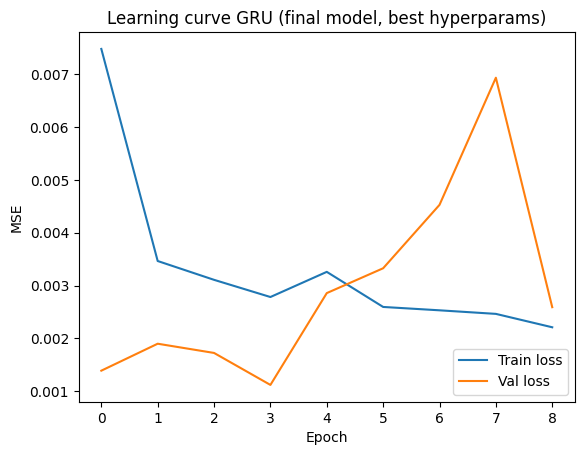

In [39]:

plt.figure()
plt.plot(history_final.history['loss'], label='Train loss')
plt.plot(history_final.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('Learning curve GRU (final model, best hyperparams)')
plt.show()


In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# dự đoán trên test (scale)
y_pred_scaled = model_final.predict(X_test)

# reshape rồi inverse scale về đơn vị USD
y_test_scaled = y_test.reshape(-1, 1)
y_pred_scaled = y_pred_scaled.reshape(-1, 1)

y_test_inv = scaler_y.inverse_transform(y_test_scaled)
y_pred_inv = scaler_y.inverse_transform(y_pred_scaled)

# Tính MSE, RMSE, MAE
mse  = mean_squared_error(y_test_inv, y_pred_inv)   # MSE
rmse = np.sqrt(mse)                                 # RMSE = sqrt(MSE)
mae  = mean_absolute_error(y_test_inv, y_pred_inv)  # MAE

print("Test MSE  (USD^2):", mse)
print("Test RMSE (USD)  :", rmse)
print("Test MAE  (USD)  :", mae)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Test MSE  (USD^2): 14.847637652583714
Test RMSE (USD)  : 3.8532632472468986
Test MAE  (USD)  : 3.058546519524495


253 253 253


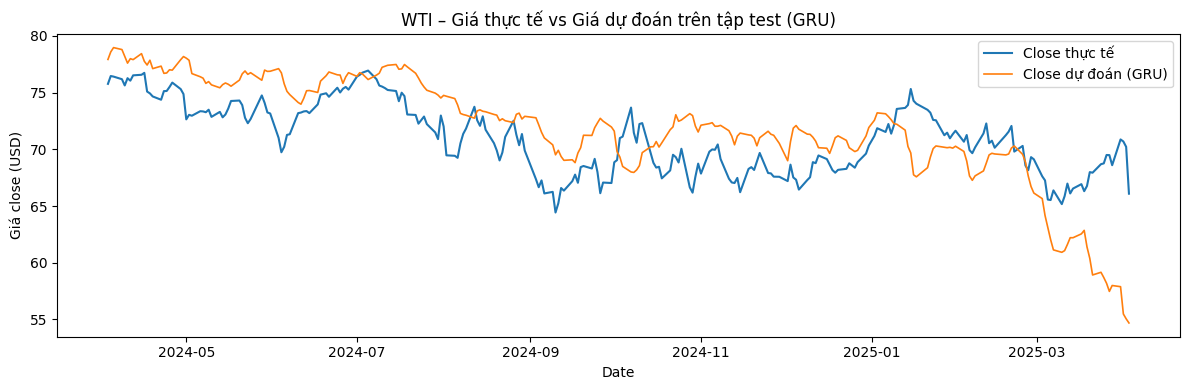

In [44]:
import matplotlib.pyplot as plt

BEST_WINDOW = 60  # = WINDOW_SIZE bạn đang dùng

# Lấy index ngày tương ứng với các mẫu trong X_test
dates_test = features_test.index[BEST_WINDOW:]   # bỏ 60 ngày đầu vì dùng làm window

print(len(dates_test), len(y_test_inv), len(y_pred_inv))  # kiểm tra cho chắc, thường sẽ bằng nhau

plt.figure(figsize=(12, 4))
plt.plot(dates_test, y_test_inv, label='Close thực tế', linewidth=1.5)
plt.plot(dates_test, y_pred_inv, label='Close dự đoán (GRU)', linewidth=1.2)
plt.xlabel('Date')
plt.ylabel('Giá close (USD)')
plt.title('WTI – Giá thực tế vs Giá dự đoán trên tập test (GRU)')
plt.legend()
plt.tight_layout()
plt.show()
